<p style="align: center;"><img align=center src="https://s8.hostingkartinok.com/uploads/images/2018/08/308b49fcfbc619d629fe4604bceb67ac.jpg" width=500 height=450/></p>

<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Продвинутый поток. Весна 2021</b></h3>

Это домашнее задание будет посвящено полноценному решению задачи машинного обучения.

Есть две части этого домашнего задания: 
* Сделать полноценный отчет о вашей работе: как вы обработали данные, какие модели попробовали и какие результаты получились (максимум 10 баллов). За каждую выполненную часть будет начислено определенное количество баллов.
* Лучшее решение отправить в соревнование на [kaggle](https://www.kaggle.com/c/advanced-dls-spring-2021/) (максимум 5 баллов). За прохождение определенного порогов будут начисляться баллы.


**Обе части будут проверяться в формате peer-review. Т.е. вашу посылку на степик будут проверять несколько других студентов и аггрегация их оценок будет выставлена. В то же время вам тоже нужно будет проверить несколько других учеников.**

**Пожалуйста, делайте свою работу чистой и понятной, чтобы облегчить проверку. Если у вас будут проблемы с решением или хочется совета, то пишите в наш чат в телеграме или в лс @runfme. Если вы захотите проаппелировать оценку, то пипшите в лс @runfme.**

**Во всех пунктах указания это минимальный набор вещей, которые стоит сделать. Если вы можете сделать какой-то шаг лучше или добавить что-то свое - дерзайте!**

# Как проверять?

Ставьте полный балл, если выполнены все рекомендации или сделано что-то более интересное и сложное. За каждый отсустствующий пункт из рекомендация снижайте 1 балл.

# Метрика

Перед решением любой задачи важно понимать, как будет оцениваться ваше решение. В данном случае мы используем стандартную для задачи классификации метрику ROC-AUC. Ее можно вычислить используя только предсказанные вероятности и истинные классы без конкретного порога классификации + она раотает даже если классы в данных сильно несбалансированны (примеров одного класса в десятки раз больше примеров длугого). Именно поэтому она очень удобна для соревнований.

Посчитать ее легко:


In [1]:
from sklearn.metrics import roc_auc_score,  roc_curve

y_true = [
    0,
    1,
    1,
    0,
    1
]

y_predictions = [
    0.1,
    0.9,
    0.4,
    0.6,
    0.61
]

roc_auc_score(y_true, y_predictions)

0.8333333333333333

# Первая часть. Исследование

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

## Загрузка данных (2 балла)

1) Посмотрите на случайные строчки. 

2) Посмотрите, есть ли в датасете незаполненные значения (nan'ы) с помощью data.isna() или data.info() и, если нужно, замените их на что-то. Будет хорошо, если вы построите табличку с количеством nan в каждой колонке.

In [3]:
data = pd.read_csv('./train.csv', na_values=" ")

In [4]:
# Для вашего удобства списки с именами разных колонок

# Числовые признаки
num_cols = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

# Категориальные признаки
cat_cols = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

feature_cols = num_cols + cat_cols
target_col = 'Churn'

Посмотрим на случайные строки

In [5]:
data.sample(10)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
2773,50,71.05,3444.85,Female,1,Yes,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,1
1224,44,20.50,865.05,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Bank transfer (automatic),0
2546,27,20.25,538.20,Female,0,No,No,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),0
3443,64,93.40,5822.30,Male,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,No,Yes,No,No,Yes,Two year,No,Bank transfer (automatic),0
667,6,45.50,285.20,Female,0,Yes,Yes,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,No,Mailed check,0
187,20,81.45,1671.60,Female,1,No,No,Yes,No,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,0
288,62,20.05,1263.90,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
633,70,84.70,5991.05,Female,0,No,No,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
4144,57,55.70,3171.60,Male,0,Yes,No,Yes,No,DSL,Yes,No,No,Yes,No,No,Month-to-month,No,Electronic check,0
9,72,61.20,4390.25,Male,0,No,No,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,Yes,Two year,Yes,Credit card (automatic),0


Смотрим на все колонки

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5273 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Мы видим, что в столбце TotalSpent есть пропущенные значения. Далее мы их заполним.

Посмотрим на описательную статистику числовых столбцов

In [7]:
data[num_cols].describe()

,ClientPeriod,MonthlySpending,TotalSpent
count,5282.000000,5282.000000,5273.000000
mean,32.397009,64.924754,2291.390461
std,24.550326,30.176464,2269.014233
min,0.000000,18.250000,18.800000
25%,9.000000,35.462500,401.100000
50%,29.000000,70.400000,1410.250000
75%,55.000000,90.050000,3807.350000
max,72.000000,118.750000,8684.800000


Видим, что значения не нормированы, значит их нужно будет нормировать.

Заполним данные в столбце TotalSpent sklearn.impute.IterativeImputer



In [8]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=0)

imputer.fit(data[num_cols])
data[num_cols] = imputer.transform(data[num_cols])

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   float64
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   float64
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

Теперь наши данные без пропусков и мы можем переходить к их анализу.

## Анализ данных (3 балла)

1) Для численных призанков постройте гистограмму (*plt.hist(...)*) или boxplot (*plt.boxplot(...)*). Для категориальных посчитайте количество каждого значения для каждого признака. Для каждой колонки надо сделать *data.value_counts()* и построить bar диаграммы *plt.bar(...)* или круговые диаграммы *plt.pie(...)* (хорошо, елси вы сможете это сделать на одном гарфике с помощью *plt.subplots(...)*). 

2) Посмотрите на распределение целевой переменной и скажите, являются ли классы несбалансированными.

3) (Если будет желание) Поиграйте с разными библиотеками для визуализации - *sns*, *pandas_visual_analysis*, etc.

Второй пункт очень важен, потому что существуют задачи классификации с несбалансированными классами. Например, это может значить, что в датасете намного больше примеров 0 класса. В таких случаях нужно 1) не использовать accuracy как метрику 2) использовать методы борьбы с imbalanced dataset (обычно если датасет сильно несбалансирован, т.е. класса 1 в 20 раз меньше класса 0).

#### Анализ числовых признаков

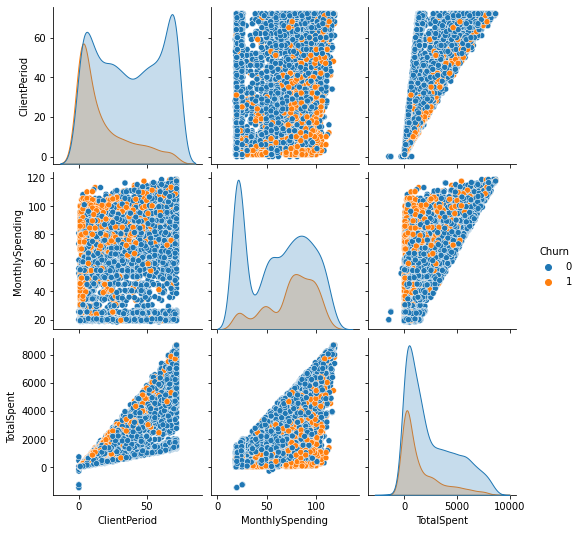

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.pairplot(data=data, hue="Churn", vars=num_cols)

Мы видим аутлаеров с ClientPeriod == 0. все они с Churn == 0 и TotalSpent<=0. Добавим индикатор того, что ClientPeriod == 0 и преобразуем ClientPeriod и TotalSpent (случайными минимальными значениями).

In [10]:
data["ClientPeriodZeroCheck"] = (data["ClientPeriod"] == 0).apply(lambda x: int(x))
cat_cols.append("ClientPeriodZeroCheck")

In [11]:
import random

min_Period = min(data.ClientPeriod[data.ClientPeriod>0])
min_Spent = min(data.TotalSpent[data.TotalSpent>0])

data.loc[data.ClientPeriod == 0, "ClientPeriod"] = [random.random() * min_Period for x in data.loc[data.ClientPeriod == 0, "ClientPeriod"]]
data.loc[data.TotalSpent<=0, "TotalSpent"] = [random.random() * min_Spent for x in data.loc[data.TotalSpent<=0, "TotalSpent"]]

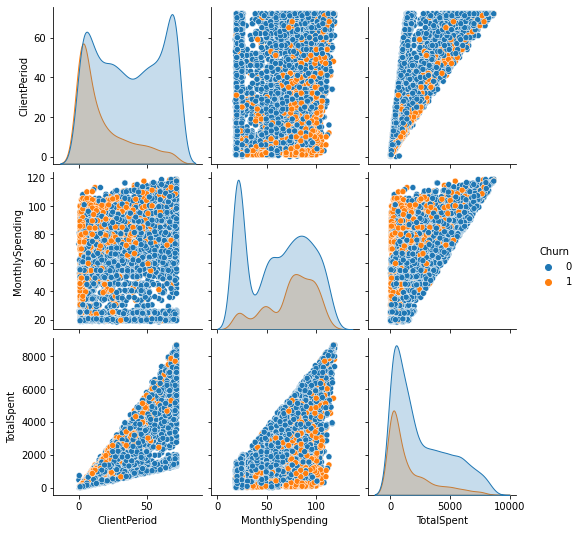

In [12]:
sns.pairplot(data=data, hue="Churn", vars=num_cols)

Теперь посмотрим на гистограммы каждого признака.

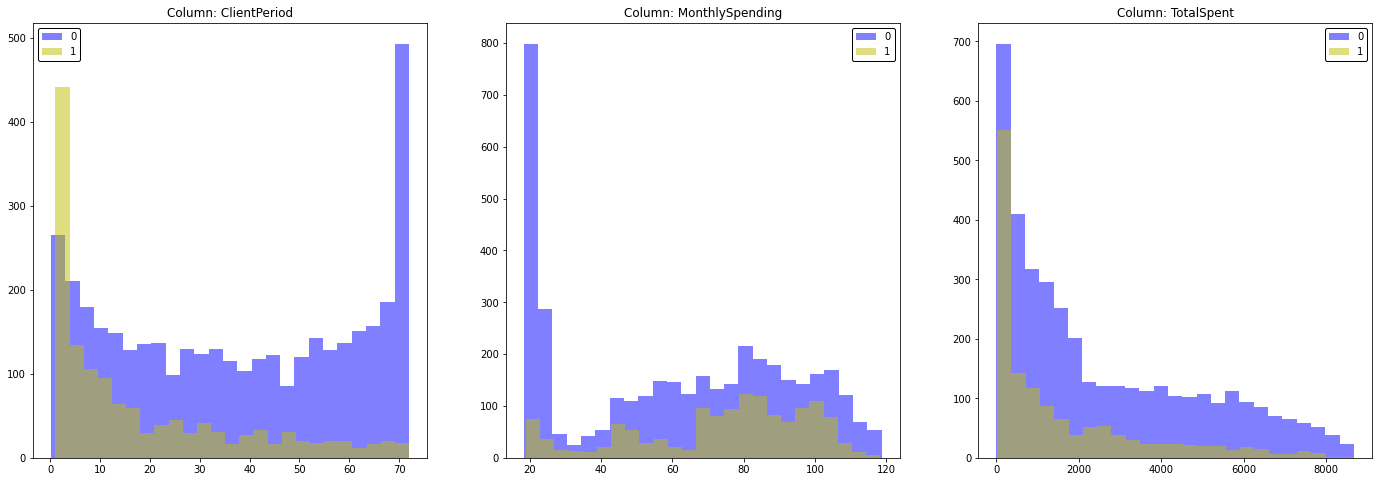

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(24,8))

ax = ax.ravel()

def churn_set(col):
    f = data[data['Churn'] == 1][col]
    s = data[data['Churn'] == 0][col]
    return f, s

for i, col in enumerate(num_cols):
    
    ax[i].set_title('Column: ' + col)
    ax[i].hist(churn_set(col)[1], bins=25, alpha=0.5, label='0', color='b')
    ax[i].hist(churn_set(col)[0], bins=25, alpha=0.5, label='1', color='y')
    legend_box = ax[i].legend(framealpha=1).get_frame()
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")
fig.show()

Полезными могут быть индикаторы ClientPeriod>50, ClientPeriod<20 и MonthlySpending<30. Также стоит логорифмировать TotalSpent

In [14]:
data["ClientPeriod50Check"] = (data["ClientPeriod"] > 50).apply(lambda x: int(x))
data["ClientPeriod20Check"] = (data["ClientPeriod"] < 20).apply(lambda x: int(x))
data["MonthlySpending30Check"] = (data["MonthlySpending"] < 30).apply(lambda x: int(x))

cat_cols.append("ClientPeriod50Check")
cat_cols.append("ClientPeriod20Check")
cat_cols.append("MonthlySpending30Check")

In [15]:
data.TotalSpent = np.log(data.TotalSpent)

#### Анализ категориальных признаков

In [16]:
len(cat_cols)

20

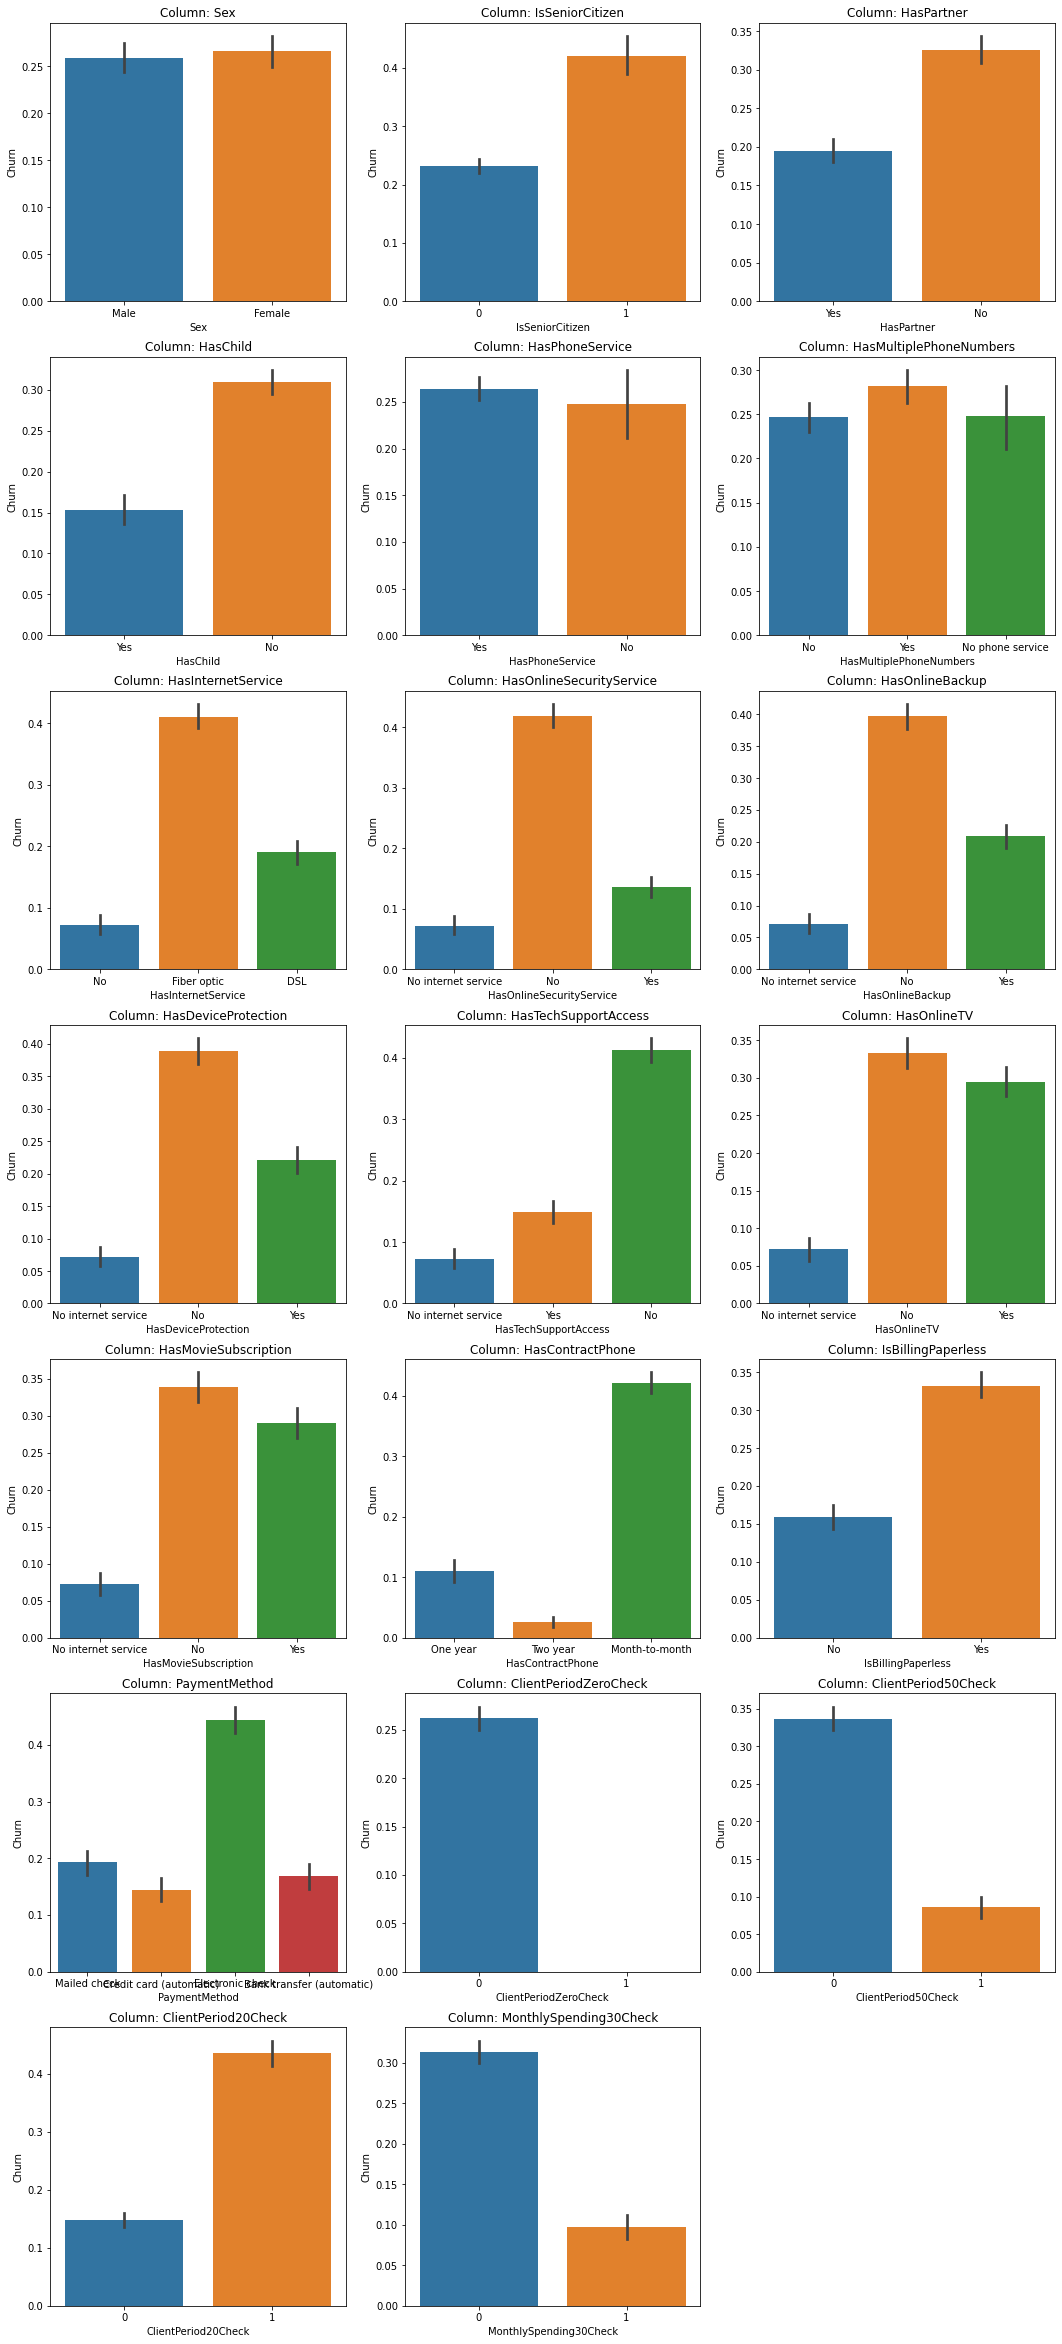

In [17]:
fig, ax = plt.subplots(7, 3, figsize=(18,42))

ax = ax.ravel()

for i, col in enumerate(cat_cols):
    
    ax[i].set_title('Column: ' + col)
    sns.barplot(x=col, y="Churn", ax=ax[i], data=data)
    legend_box.set_facecolor("white")
    legend_box.set_edgecolor("black")

[fig.delaxes(ax[ind]) for ind in range(len(cat_cols), 21)]

fig.show()

Мы видим, что много столбцов, которые имеют разное соотношение в столбце Churn в зависимости от категорий.

In [18]:
for cat in cat_cols:
  print(data[cat].value_counts())
  print()

Male      2655
Female    2627
Name: Sex, dtype: int64

0    4440
1     842
Name: IsSeniorCitizen, dtype: int64

No     2705
Yes    2577
Name: HasPartner, dtype: int64

No     3676
Yes    1606
Name: HasChild, dtype: int64

Yes    4761
No      521
Name: HasPhoneService, dtype: int64

No                  2511
Yes                 2250
No phone service     521
Name: HasMultiplePhoneNumbers, dtype: int64

Fiber optic    2341
DSL            1800
No             1141
Name: HasInternetService, dtype: int64

No                     2612
Yes                    1529
No internet service    1141
Name: HasOnlineSecurityService, dtype: int64

No                     2332
Yes                    1809
No internet service    1141
Name: HasOnlineBackup, dtype: int64

No                     2317
Yes                    1824
No internet service    1141
Name: HasDeviceProtection, dtype: int64

No                     2604
Yes                    1537
No internet service    1141
Name: HasTechSupportAccess, dtype: in

Видим, что почти в каждом столбце категории несбалансированные.

Теперь посмотрим на целевую переменную.

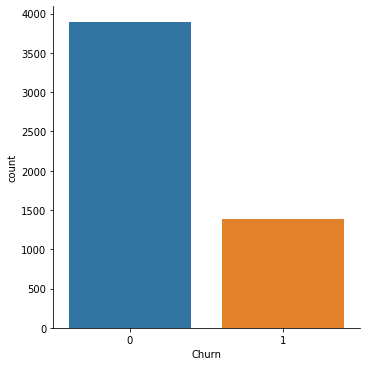

In [19]:
sns.catplot(x=target_col, kind="count", data=data)

In [20]:
data[target_col].value_counts()

0    3898
1    1384
Name: Churn, dtype: int64

Видим, что она также несбалансирована.

In [21]:
feature_cols = num_cols + cat_cols

Теперь перейдем к построению моделей.

## Применение линейных моделей (3 балла)

1) Обработайте данные для того, чтобы к ним можно было применить LogisticRegression. Т.е. отнормируйте числовые признаки, а категориальные закодируйте с помощью one-hot-encoding'а. 

2) С помощью кроссвалидации или разделения на train/valid выборку протестируйте разные значения гиперпараметра C и выберите лучший (можно тестировать С=100, 10, 1, 0.1, 0.01, 0.001) по метрике ROC-AUC. 

Если вы разделяете на train/valid, то используйте LogisticRegressionCV. Он сам при вызове .fit() подберет параметр С. (не забудьте передать scroing='roc_auc', чтобы при кроссвалидации сравнивались значения этой метрики, и refit=True, чтобы при потом модель обучилась на всем датасете с лучшим параметром C). 


(более сложный вариант) Если вы будете использовать кроссвалидацию, то преобразования данных и LogisticRegression нужно соединить в один Pipeline с помощью make_pipeline, как это делалось во втором семинаре. Потом pipeline надо передать в GridSearchCV. Для one-hot-encoding'a можно испльзовать комбинацию LabelEncoder + OneHotEncoder (сначала превращаем строчки в числа, а потом числа првращаем в one-hot вектора.)

In [22]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.pipeline import make_pipeline

In [23]:
dummy_features = pd.get_dummies(data[cat_cols], drop_first=True)

In [24]:
scaler = MinMaxScaler()

X = pd.concat([data[num_cols], dummy_features], axis=1)
X_scaled = scaler.fit_transform(X)

X_origin = data[feature_cols]
y = data[target_col]

In [25]:
X_train, X_valid, y_train, y_valid = train_test_split(X_scaled, y.values, 
                                                      test_size = 0.2, random_state=1)

In [26]:
X_train.shape, y_train.shape

((4225, 34), (4225,))

In [78]:
%%time

Cs = [1, 0.1, 0.01, 0.001]
l1r = [0, 0.25, 0.5, 0.75, 1]
LRCV = LogisticRegressionCV(Cs=Cs, n_jobs=-1, cv=5, scoring="roc_auc", max_iter=10 ** 5,
                            penalty='elasticnet', l1_ratios=l1r, solver="saga",
                            random_state=1).fit(X_train, y_train)

CPU times: user 14.7 s, sys: 1.71 s, total: 16.4 s
Wall time: 8.41 s


Выпишите какое лучшее качество и с какими параметрами вам удалось получить

In [79]:
print('Max auc_roc:', LRCV.scores_[1].mean(axis=0).max()) 

Max auc_roc: 0.8462346459846872


In [80]:
print("Fitted C: ", LRCV.C_[0], "\nFitted l1r: ", LRCV.l1_ratio_[0])

Fitted C:  1.0 
Fitted l1r:  1


In [81]:
def roc_plot(y_train, y_train_predicted, y_test, y_test_predicted):
  train_auc = roc_auc_score(y_train, y_train_predicted)
  test_auc = roc_auc_score(y_test, y_test_predicted)

  plt.figure(figsize=(10,7))
  plt.plot(*roc_curve(y_train, y_train_predicted)[:2], label='train AUC={:.4f}'.format(train_auc))
  plt.plot(*roc_curve(y_test, y_test_predicted)[:2], label='test AUC={:.4f}'.format(test_auc))
  legend_box = plt.legend(fontsize='large', framealpha=1).get_frame()
  legend_box.set_facecolor("white")
  legend_box.set_edgecolor("black")
  plt.plot(np.linspace(0,1,100), np.linspace(0,1,100))
  plt.show()

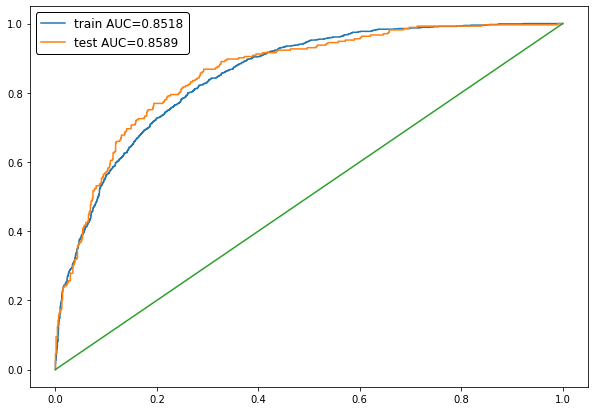

In [82]:
y_train_predicted = LRCV.predict_proba(X_train)[:, 1]
y_valid_predicted = LRCV.predict_proba(X_valid)[:, 1]

roc_plot(y_train, y_train_predicted, y_valid, y_valid_predicted)

Выпишем наиболее значимые стоблцы

In [32]:
features_coef = np.stack((X.columns.values, LRCV.coef_[0]), axis=1)

In [33]:
for row in features_coef[(-abs(features_coef[:,1])).argsort()][:10]:
  print(row[0],": ", row[1])

HasContractPhone_Two year :  -1.2023092153506048
TotalSpent :  -1.074628185471643
ClientPeriod :  -0.787627500164844
HasInternetService_Fiber optic :  0.7291061987997909
ClientPeriod20Check :  0.5892529440563584
HasContractPhone_One year :  -0.5625927019517853
HasOnlineSecurityService_Yes :  -0.4793718887525092
IsBillingPaperless_Yes :  0.42271693402546395
HasTechSupportAccess_Yes :  -0.3399313936712783
PaymentMethod_Electronic check :  0.30045472200030415


## Применение градиентного бустинга (2 балла)

Если вы хотите получить баллы за точный ответ, то стоит попробовать градиентный бустинг. Часто градиентный бустинг с дефолтными параметрами даст вам 80% результата за 0% усилий.

Мы будем использовать catboost, поэтому нам не надо кодировать категориальные признаки. catboost сделает это сам (в .fit() надо передать cat_features=cat_cols). А численные признаки нормировать для моделей, основанных на деревьях не нужно.

1) Разделите выборку на train/valid. Протестируйте catboost cо стандартными параметрами.

2) Протестируйте разные занчения параметроа количества деревьев и learning_rate'а и выберите лучшую по метрике ROC-AUC комбинацию. 

(Дополнительно) Есть некоторые сложности с тем, чтобы использовать CatBoostClassifier вместе с GridSearchCV, поэтому мы не просим использовать кроссвалидацию. Но можете попробовать)

In [34]:
!pip install catboost
import catboost

In [35]:
X_train_origin, X_valid_origin, _, _ = train_test_split(X_origin.values, y.values, 
                                                       test_size=0.2, 
                                                       random_state=1)

In [36]:
cat_indexes = [list(X_origin.columns.values).index(x) for x in cat_cols]
cat_indexes

[3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22]

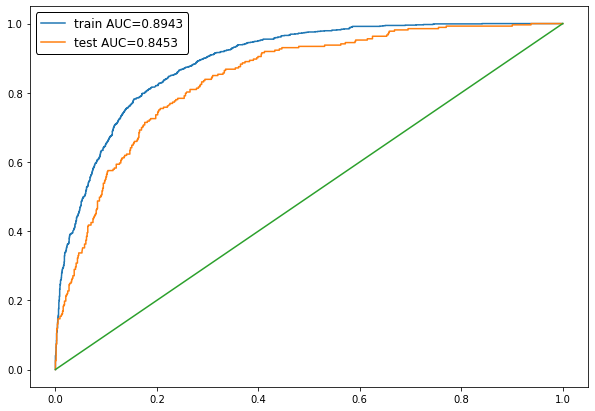

In [37]:
boosting_model = catboost.CatBoostClassifier(n_estimators=100, silent=True, 
                                             cat_features=cat_indexes)

boosting_model.fit(X_train_origin, y_train)

y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_valid_predicted = boosting_model.predict_proba(X_valid_origin)[:, 1]

roc_plot(y_train, y_train_predicted, y_valid, y_valid_predicted)

In [38]:
boosting_model = catboost.CatBoostClassifier(n_estimators=200, silent=True,
                                             cat_features=cat_indexes,
                                             eval_metric='AUC')

params = {
    'l2_leaf_reg': np.linspace(0, 1, 5),
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.1, 1],
    }
boosting_model.grid_search(params, 
                           X_origin, 
                           y, 
                           refit=True,
                           train_size=0.8,
                           verbose=True,
                           plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.8709016393
bestIteration = 199

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
0:	loss: 0.8709016	best: 0.8709016 (0)	total: 1.86s	remaining: 1m 21s

bestTest = 0.8726833276
bestIteration = 37

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
1:	loss: 0.8726833	best: 0.8726833 (1)	total: 3.74s	remaining: 1m 20s

bestTest = 0.8604384004
bestIteration = 4

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
2:	loss: 0.8604384	best: 0.8726833 (1)	total: 5.72s	remaining: 1m 20s

bestTest = 0.8711643548
bestIteration = 197

Metric AUC is not calculated on train by default. To calculate this metric on train, add hints=skip_train~false to metric parameters.
3:	loss: 0.8711644	best: 0.8726833 (1)	total: 7.47s	remaining: 1m 16s

be

{'cv_results': defaultdict(list,
             {'iterations': [0,
               1,
               2,
               3,
               4,
               5,
               6,
               7,
               8,
               9,
               10,
               11,
               12,
               13,
               14,
               15,
               16,
               17,
               18,
               19,
               20,
               21,
               22,
               23,
               24,
               25,
               26,
               27,
               28,
               29,
               30,
               31,
               32,
               33,
               34,
               35,
               36,
               37,
               38,
               39,
               40,
               41,
               42,
               43,
               44,
               45,
               46,
               47,
               48,
               49,
             

Выпишите какое лучшее качество и с какими параметрами вам удалось получить

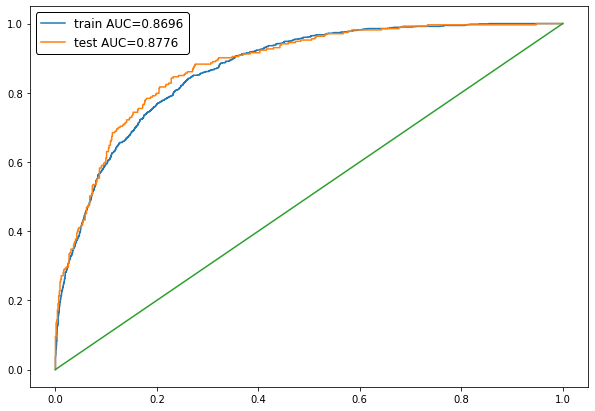

In [39]:
y_train_predicted = boosting_model.predict_proba(X_train_origin)[:, 1]
y_valid_predicted = boosting_model.predict_proba(X_valid_origin)[:, 1]

roc_plot(y_train, y_train_predicted, y_valid, y_valid_predicted)

AUC: 0.846

params': {'depth': 4, 'l2_leaf_reg': 0.75, 'learning_rate': 0.1}}

## Применение SVM

In [40]:
from sklearn.svm import SVC

In [41]:
svm = SVC(probability=True)

In [42]:
%%time
svm.fit(X_train, y_train)

CPU times: user 4.44 s, sys: 49.3 ms, total: 4.49 s
Wall time: 4.49 s


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

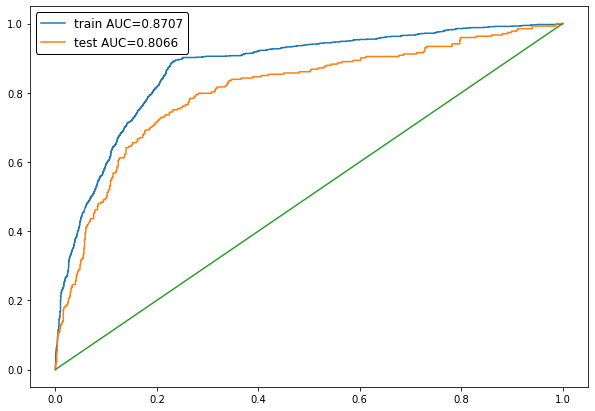

In [43]:
y_train_predicted = svm.predict_proba(X_train)[:, 1]
y_valid_predicted = svm.predict_proba(X_valid)[:, 1]

roc_plot(y_train, y_train_predicted, y_valid, y_valid_predicted)

In [44]:
C = [0.01, 0.1, 1, 10]
kernel = ["linear", "rbf"]
gamma = [0.01, 0.1, 1]
decision_function_shape = ["ovr"]

In [45]:
%%time
grid_svm = GridSearchCV(estimator=svm, cv=3, scoring="roc_auc",
                                        param_grid=dict(kernel=kernel, C=C, gamma=gamma,
                                                        decision_function_shape=decision_function_shape))
opt = grid_svm.fit(X_train, y_train)

CPU times: user 2min 31s, sys: 71.2 ms, total: 2min 31s
Wall time: 2min 31s


In [46]:
print(grid_svm.best_score_)
print(grid_svm.best_params_)

0.8359295029569869
{'C': 0.01, 'decision_function_shape': 'ovr', 'gamma': 0.01, 'kernel': 'linear'}


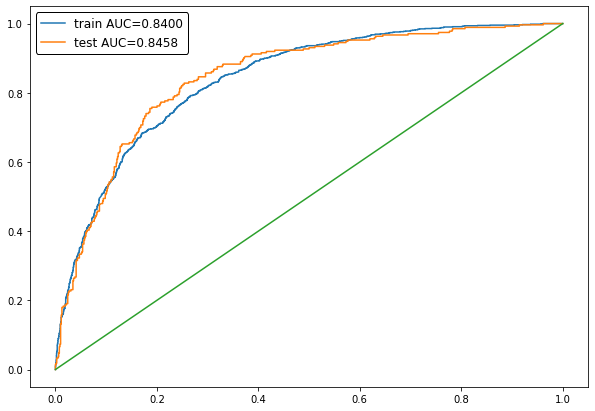

In [47]:
y_train_predicted = opt.predict_proba(X_train)[:, 1]
y_valid_predicted = opt.predict_proba(X_valid)[:, 1]

roc_plot(y_train, y_train_predicted, y_valid, y_valid_predicted)

## Стекинг

In [109]:
def compute_meta_feature(models, X_, X_orig_):
  meta_features = np.zeros((X_.shape[0], 0))

  lr_f = models[0].predict_proba(X_)[:, 1]
  boost_f = models[1].predict_proba(X_orig_)[:, 1]
  svm_f = models[2].predict_proba(X_)[:, 1]

  meta_features = np.append(meta_features, lr_f.reshape((lr_f.size, 1)), axis=1)
  meta_features = np.append(meta_features, boost_f.reshape((boost_f.size, 1)), axis=1)
  meta_features = np.append(meta_features, svm_f.reshape((svm_f.size, 1)), axis=1)

  return meta_features

In [110]:
models = [LRCV, boosting_model, opt]
meta_train = compute_meta_feature(models, X_train, X_train_origin)
meta_valid = compute_meta_feature(models, X_valid, X_valid_origin)

In [111]:
stacking_model = LogisticRegression()
stacking_model.fit(meta_valid, y_valid)

y_train_predicted = stacking_model.predict_proba(meta_train)[:, 1]
y_valid_predicted = stacking_model.predict_proba(meta_valid)[:, 1]

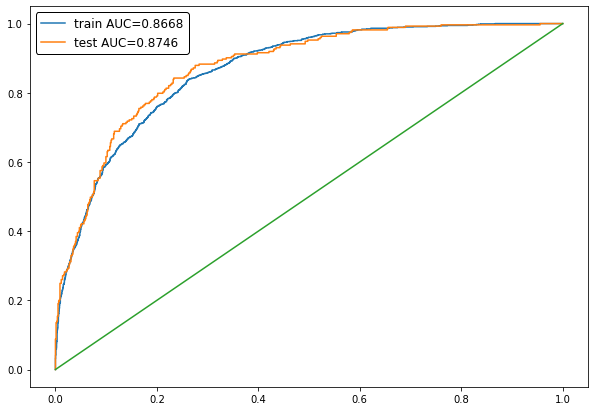

In [112]:
roc_plot(y_train, y_train_predicted, y_valid, y_valid_predicted)

In [113]:
%%time

Cs = [0.1, 0.01, 0.001]
l1r = [0, 0.25, 0.5, 0.75, 1]
stacking_CV = LogisticRegressionCV(Cs=Cs, n_jobs=-1, cv=5, scoring="roc_auc", max_iter=10 ** 5,
                            penalty='elasticnet', l1_ratios=l1r, solver="saga",
                            random_state=1).fit(meta_valid, y_valid)

CPU times: user 340 ms, sys: 39.1 ms, total: 379 ms
Wall time: 307 ms


In [114]:
print("Fitted C: ", stacking_CV.C_[0], "\nFitted l1r: ", stacking_CV.l1_ratio_[0])

Fitted C:  0.1 
Fitted l1r:  1


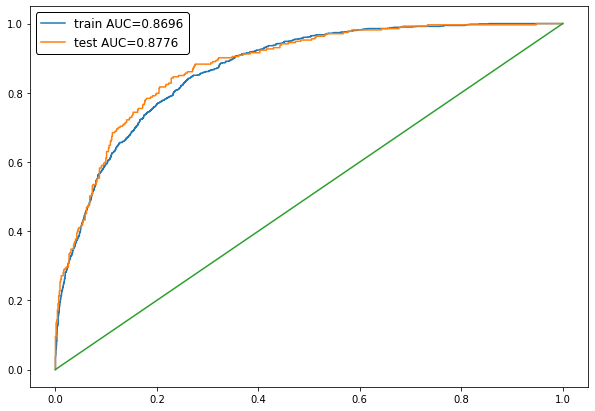

In [115]:
y_train_predicted = stacking_CV.predict_proba(meta_train)[:, 1]
y_valid_predicted = stacking_CV.predict_proba(meta_valid)[:, 1]

roc_plot(y_train, y_train_predicted, y_valid, y_valid_predicted)

# Предсказания

In [116]:
best_model_LR = LogisticRegression(C=1, n_jobs=-1, 
                                max_iter=10 ** 5,
                                penalty='elasticnet', 
                                l1_ratio=1, 
                                solver="saga",
                                random_state=1).fit(X_scaled, y)

In [117]:
best_model_CB = catboost.CatBoostClassifier(n_estimators=200, silent=True, 
                                            depth=4, l2_leaf_reg=0.75, learning_rate=0.1,
                                            cat_features=cat_indexes)

best_model_CB.fit(X_origin, y)

In [118]:
best_model_CB = boosting_model

In [119]:
best_model_svm = SVC(**grid_svm.best_params_, probability=True).fit(X_scaled, y)

Теперь сделаем стекинг

In [120]:
best_models = [best_model_LR, best_model_CB, best_model_svm]
meta_data = compute_meta_feature(best_models, X_scaled, X_origin)

In [121]:
best_stacking_model = LogisticRegression(C=0.001, 
                                         n_jobs=-1, 
                                         max_iter=10 ** 5,
                                         penalty='elasticnet', 
                                         l1_ratio=0, 
                                         solver="saga",
                                         random_state=1).fit(meta_data, y)

In [122]:
best_stacking_model = stacking_CV

In [123]:
roc_auc_score(y, best_stacking_model.predict_proba(meta_data)[:,1])

0.8710940396290375

Считаем и преобразуем данные

In [124]:
X_test = pd.read_csv('./test.csv', na_values=" ")


In [125]:
def data_prepare(data):
  data[num_cols] = imputer.transform(data[num_cols])

  data["ClientPeriodZeroCheck"] = (data["ClientPeriod"] == 0).apply(lambda x: int(x))

  data.loc[data.ClientPeriod == 0, "ClientPeriod"] = [random.random() * min_Period for x in data.loc[data.ClientPeriod == 0, "ClientPeriod"]]
  data.loc[data.TotalSpent<=0, "TotalSpent"] = [random.random() * min_Spent for x in data.loc[data.TotalSpent<=0, "TotalSpent"]]

  data["ClientPeriod50Check"] = (data["ClientPeriod"] > 50).apply(lambda x: int(x))
  data["ClientPeriod20Check"] = (data["ClientPeriod"] < 20).apply(lambda x: int(x))
  data["MonthlySpending30Check"] = (data["MonthlySpending"] < 30).apply(lambda x: int(x))

  data.TotalSpent = np.log(data.TotalSpent)

  dummy_features = pd.get_dummies(data[cat_cols], drop_first=True)

  X_test = pd.concat([data[num_cols], dummy_features], axis=1)
  X_test_scaled = scaler.fit_transform(X_test)

  return X_test_scaled


In [126]:
def data_prepare_for_cat(data):
  data[num_cols] = imputer.transform(data[num_cols])

  data["ClientPeriodZeroCheck"] = (data["ClientPeriod"] == 0).apply(lambda x: int(x))

  data.loc[data.ClientPeriod == 0, "ClientPeriod"] = [random.random() * min_Period for x in data.loc[data.ClientPeriod == 0, "ClientPeriod"]]
  data.loc[data.TotalSpent<=0, "TotalSpent"] = [random.random() * min_Spent for x in data.loc[data.TotalSpent<=0, "TotalSpent"]]

  data["ClientPeriod50Check"] = (data["ClientPeriod"] > 50).apply(lambda x: int(x))
  data["ClientPeriod20Check"] = (data["ClientPeriod"] < 20).apply(lambda x: int(x))
  data["MonthlySpending30Check"] = (data["MonthlySpending"] < 30).apply(lambda x: int(x))

  data.TotalSpent = np.log(data.TotalSpent)

  X_test = data[feature_cols]

  return X_test

In [127]:
X_test_scaled_ = data_prepare(X_test)
X_test_orig_ = data_prepare_for_cat(X_test)

In [128]:
meta_test = compute_meta_feature(best_models, X_test_scaled_, X_test_orig_)

In [132]:
predict = meta_test[:,0] * 0.4 + meta_test[:,1] * 0.35 + meta_test[:,2] * 0.25
predict[:10]

array([0.03701431, 0.74742302, 0.77993274, 0.01077198, 0.00750176,
       0.1149937 , 0.64129774, 0.26645886, 0.08969536, 0.43144799])

In [133]:
submission = pd.read_csv('./submission.csv')

submission['Churn'] = predict  # best_stacking_model.predict_proba(meta_test)[:,1]  # best_model.predict(X_test)
submission.to_csv('./submission_8.csv', index=False)

# Kaggle (5 баллов)

Как выставить баллы:

1) 1 >= roc auc > 0.84 это 5 баллов

2) 0.84 >= roc auc > 0.7 это 3 балла

3) 0.7 >= roc auc > 0.6 это 1 балл

4) 0.6 >= roc auc это 0 баллов


Для выполнения задания необходимо выполнить следующие шаги.
* Зарегистрироваться на платформе [kaggle.com](kaggle.com). Процесс выставления оценок будет проходить при подведении итогового рейтинга. Пожалуйста, укажите во вкладке Team -> Team name свои имя и фамилию в формате Имя_Фамилия (важно, чтобы имя и фамилия совпадали с данными на Stepik).
* Обучить модель, получить файл с ответами в формате .csv и сдать его в конкурс. Пробуйте и экспериментируйте. Обратите внимание, что вы можете выполнять до 20 попыток сдачи на kaggle в день.
* После окончания соревнования отправить в итоговый ноутбук с решением на степик. 
* После дедлайна проверьте посылки других участников по критериям. Для этого надо зайти на степик, скачать их ноутбук и проверить скор в соревновании.